# Bayesian Neural Network (VI) for classification (under Development)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import mxfusion as mf
import mxnet as mx
import numpy as np
import mxnet.gluon.nn as nn
import mxfusion.components
import mxfusion.inference

### Generate Synthetic Data

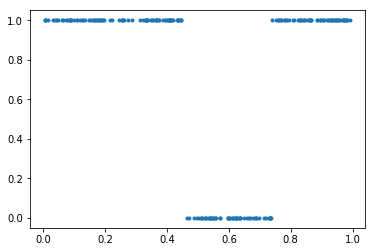

In [2]:
import GPy
%matplotlib inline
from pylab import *

np.random.seed(4)
k = GPy.kern.RBF(1, lengthscale=0.1)
x = np.random.rand(200,1)
y = np.random.multivariate_normal(mean=np.zeros((200,)), cov=k.K(x), size=(1,)).T>0.
plot(x[:,0], y[:,0], '.')

In [3]:
D = 10
net = nn.HybridSequential(prefix='nn_')
with net.name_scope():
    net.add(nn.Dense(D, activation="tanh", flatten=False, in_units=1))
    net.add(nn.Dense(D, activation="tanh", flatten=False, in_units=D))
    net.add(nn.Dense(2, flatten=False, in_units=D))
net.initialize(mx.init.Xavier(magnitude=1))

In [4]:
from mxfusion.components.variables.var_trans import PositiveTransformation
from mxfusion.inference import VariationalPosteriorForwardSampling

In [5]:
m = mf.Model()
m.N = mf.Variable()
m.f = mf.functions.MXFusionGluonFunction(net, num_outputs=1, broadcastable=False)
m.x = mf.Variable(shape=(m.N,1))
m.r = m.f(m.x)
for _,v in m.r.factor.block_variables:
    v.set_prior(mf.components.distributions.Normal(mean=mx.nd.array([0]),variance=mx.nd.array([3.])))
m.y = mf.distributions.Categorical.define_variable(log_prob=m.r,  shape=(m.N,1), num_classes=2)
print(m)

Variable(5ad42) ~ Normal(mean=Variable(6d762), variance=Variable(27862))
Variable(8f535) ~ Normal(mean=Variable(0ecff), variance=Variable(12260))
Variable(3176b) ~ Normal(mean=Variable(c93be), variance=Variable(ced09))
Variable(2f954) ~ Normal(mean=Variable(68f71), variance=Variable(c85cc))
Variable(af0d3) ~ Normal(mean=Variable(f23a5), variance=Variable(db8d5))
Variable(89aae) ~ Normal(mean=Variable(1cf7e), variance=Variable(f283b))
r = GluonFunctionEvaluation(nn_dense0_weight=Variable(89aae), nn_dense0_bias=Variable(af0d3), nn_dense1_weight=Variable(2f954), nn_dense1_bias=Variable(3176b), nn_dense2_weight=Variable(8f535), nn_dense2_bias=Variable(5ad42), nn_input_0=x)
y ~ Categorical(log_prob=r)


In [6]:
from mxfusion.inference import BatchInferenceLoop, create_Gaussian_meanfield, GradBasedInference, StochasticVariationalInference, MAP

In [7]:
observed = [m.y, m.x]
q = create_Gaussian_meanfield(model=m, observed=observed)
alg = StochasticVariationalInference(num_samples=5, model=m, posterior=q, observed=observed)
infr = GradBasedInference(inference_algorithm=alg, grad_loop=BatchInferenceLoop())

In [8]:
infr.initialize(y=mx.nd.array(y), x=mx.nd.array(x))

In [9]:
for v_name, v in m.r.factor.block_variables:
    uuid = v.uuid
    loc_uuid = infr.inference_algorithm.posterior[uuid].factor.variance.uuid
    a = infr.params.param_dict[loc_uuid].data().asnumpy()
    a[:] = 1e-8
    infr.params[infr.inference_algorithm.posterior[uuid].factor.mean] = net.collect_params()[v_name].data()
    infr.params[infr.inference_algorithm.posterior[uuid].factor.variance] = mx.nd.array(a)

In [10]:
infr.run(max_iter=500, learning_rate=1e-1, y=mx.nd.array(y), x=mx.nd.array(x), verbose=True)

Iteration 1 logL: -1546.0653076171875
Iteration 2 logL: -1525.91796875
Iteration 3 logL: -1516.2220458984375
Iteration 4 logL: -1506.6162109375
Iteration 5 logL: -1493.142578125
Iteration 6 logL: -1491.718017578125
Iteration 7 logL: -1486.9036865234375
Iteration 8 logL: -1473.222900390625
Iteration 9 logL: -1460.4859619140625
Iteration 10 logL: -1458.54345703125
Iteration 11 logL: -1448.301513671875
Iteration 12 logL: -1439.9364013671875
Iteration 13 logL: -1435.6376953125
Iteration 14 logL: -1426.91845703125
Iteration 15 logL: -1416.010498046875
Iteration 16 logL: -1412.5848388671875
Iteration 17 logL: -1400.81787109375
Iteration 18 logL: -1389.749755859375
Iteration 19 logL: -1384.2734375
Iteration 20 logL: -1376.7227783203125
Iteration 21 logL: -1361.32373046875
Iteration 22 logL: -1361.332275390625
Iteration 23 logL: -1345.169921875
Iteration 24 logL: -1340.9359130859375
Iteration 25 logL: -1340.800048828125
Iteration 26 logL: -1323.4241943359375
Iteration 27 logL: -1314.0883789062

Iteration 218 logL: -169.4395751953125
Iteration 219 logL: -165.57479858398438
Iteration 220 logL: -182.1772918701172
Iteration 221 logL: -180.68096923828125
Iteration 222 logL: -162.6793212890625
Iteration 223 logL: -164.8264617919922
Iteration 224 logL: -155.75379943847656
Iteration 225 logL: -186.3856201171875
Iteration 226 logL: -141.95481872558594
Iteration 227 logL: -170.60086059570312
Iteration 228 logL: -181.46908569335938
Iteration 229 logL: -180.71090698242188
Iteration 230 logL: -166.70156860351562
Iteration 231 logL: -168.08798217773438
Iteration 232 logL: -176.33721923828125
Iteration 233 logL: -162.26913452148438
Iteration 234 logL: -147.10694885253906
Iteration 235 logL: -164.4463348388672
Iteration 236 logL: -161.24822998046875
Iteration 237 logL: -155.4529571533203
Iteration 238 logL: -170.67617797851562
Iteration 239 logL: -160.91525268554688
Iteration 240 logL: -146.65541076660156
Iteration 241 logL: -146.2089385986328
Iteration 242 logL: -191.83047485351562
Iteratio

Iteration 430 logL: -145.3683624267578
Iteration 431 logL: -143.3435516357422
Iteration 432 logL: -155.85325622558594
Iteration 433 logL: -133.5447235107422
Iteration 434 logL: -141.08251953125
Iteration 435 logL: -139.56387329101562
Iteration 436 logL: -144.58441162109375
Iteration 437 logL: -152.3759307861328
Iteration 438 logL: -134.393798828125
Iteration 439 logL: -164.20071411132812
Iteration 440 logL: -132.19578552246094
Iteration 441 logL: -173.5281219482422
Iteration 442 logL: -137.7017364501953
Iteration 443 logL: -151.94773864746094
Iteration 444 logL: -135.4544677734375
Iteration 445 logL: -139.7561798095703
Iteration 446 logL: -146.60215759277344
Iteration 447 logL: -168.17799377441406
Iteration 448 logL: -136.48629760742188
Iteration 449 logL: -165.04998779296875
Iteration 450 logL: -201.03378295898438
Iteration 451 logL: -174.78173828125
Iteration 452 logL: -158.18133544921875
Iteration 453 logL: -155.8029327392578
Iteration 454 logL: -140.907470703125
Iteration 455 logL:

In [11]:
for uuid, v in infr.inference_algorithm.posterior.variables.items():
    if uuid in infr.params.param_dict:
        print(v.name, infr.params[v])

None 
[[-4.2562084 ]
 [-2.1897657 ]
 [-2.7514694 ]
 [-1.8618754 ]
 [ 0.05935706]
 [ 2.3460457 ]
 [-2.6491752 ]
 [-1.2179427 ]
 [-0.08034295]
 [-0.5979197 ]]
<NDArray 10x1 @cpu(0)>
None 
[[0.01767311]
 [0.00603309]
 [0.00848725]
 [0.05524571]
 [0.68462664]
 [0.00412718]
 [0.03144019]
 [0.11763541]
 [2.0121076 ]
 [0.37226263]]
<NDArray 10x1 @cpu(0)>
None 
[ 1.6983228   1.4742194   1.775172    0.6392376   0.31661415 -1.6325905
  1.398058    0.7429083   0.04331838  0.3991743 ]
<NDArray 10 @cpu(0)>
None 
[0.00463977 0.00697836 0.00277748 0.04407028 0.45794868 0.00267045
 0.01026547 0.07324851 0.6038953  0.06482685]
<NDArray 10 @cpu(0)>
None 
[[-5.0367075e-01 -3.6483032e-01 -3.4889570e-01 -3.7278756e-01
  -5.8295298e-01  2.0773776e-01 -5.1646495e-01 -5.6319767e-01
   1.2088771e-01 -3.6126822e-02]
 [ 3.2355504e-03 -3.6068845e-01 -1.8626985e-01 -1.8437026e-01
   6.3100457e-04  4.4206291e-01 -2.7084729e-02 -3.1543028e-01
  -2.8092265e-01 -2.6803422e-01]
 [-1.4353344e-01  2.7556152e+00  2.756637

In [12]:
xt = np.linspace(0,1,100)[:,None]

In [13]:
infr2 = VariationalPosteriorForwardSampling(10, [m.x], infr, [m.r])
res = infr2.run(x=mx.nd.array(xt))

In [14]:
yt = res[m.r].asnumpy()

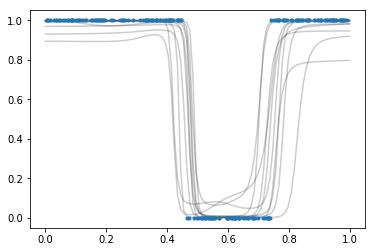

In [15]:
yt_mean = yt.mean(0)
yt_std = yt.std(0)
for i in range(yt.shape[0]):
    plot(xt[:,0],1./(1+np.exp(yt[i,:,0]-yt[i,:,1])),'k',alpha=0.2)
plot(x[:,0],y[:,0],'.')